In [ ]:
import os
import numpy as np
import pandas as pd
import utilities_dataset as uta
import re
#Automcompletar rápido
%config IPCompleter.greedy=True

import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer=WordNetLemmatizer()
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
raiz= "C:/Proyectos/X01_sentiment_analyzer"

path_stopwords = raiz+"/01_Documentos/stopwords.txt"
stopwords = [c.strip() for c in open(path_stopwords)]

datos = uta.load_dataset_train(raiz=raiz)
datos_test = uta.load_dataset_val(raiz=raiz)

Y = datos['sentiment'].copy()
X = datos[['text']].fillna("-").copy()

In [4]:
 # ['getting hungry',
 # 'too big',
 # 'looking forward',
 # 'cant wait',
 # 'CC',
 # 'CD',
 # 'DT',
 # 'EX',
 # 'FW',
 # 'IN',
 # 'JJ',
 # 'JJR',
 # 'JJS',
 # 'LS',
 # 'MD',
 # 'NN',
 # 'NNP',
 # 'NNPS',
 # 'NNS',
 # 'PDT',
 # 'POS',
 # 'PRP',
 # 'RB',
 # 'RBR',
 # 'RBS',
 # 'RP',
 # 'SYM',
 # 'TO',
 # 'UH',
 # 'VB',
 # 'VBD',
 # 'VBG',
 # 'VBN',
 # 'VBP',
 # 'VBZ',
 # 'WDT',
 # 'WP',
 # 'WRB',
 # 'conteo_exclamaciones',
 # 'conteo_ptos_suspensivos']

# CLASES

In [ ]:
class Sentiment_Vectorizer:
    def __init__(self, params_Tfidf=None ):
        self.nombres_variables = None
        self.params_Tfidf = params_Tfidf
        self._get_parameters()
        self.cv = None
        self.num_variables = None
        self.nombres_variables =None
        
    def _get_parameters(self):
        if self.params_Tfidf is None:
            self.params_Tfidf = {"ngram_range":(1, 1),
                         "min_df":4,
                         "max_df":0.5,             
                         "stop_words": "english",
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         "max_features":300}
            
    def fit_vectorizer(self,data):
        """v1.0"""
        X = data.copy()

        cv=TfidfVectorizer(**self.params_Tfidf)
        cv.fit(X['texto'])
        
        self.nombres_variables = cv.get_feature_names_out().tolist()
        self.num_variables = len(self.nombres_variables)
        self.cv = cv
        return None

    def transform_vectorizer(self, data):
        dfs = self.cv.transform(data["texto"])
        return  pd.DataFrame.sparse.from_spmatrix(dfs,columns = self.nombres_variables  )
        


    def fit_transform_vectorizer(self,data):
        self.fit_vectorizer(data)
        return self.transform_vectorizer( data)

class Sentiment_Evaluator:
    def __init__(self, model, params_model=None):
        
        self.model = model
        self.params_model = params_model
        if params_model is None:
            self.model = self.model()
        else:
            self.model = self.model(**params_model)
        
    def fit(self,train_data,Y, scoring="f1_macro" , cv=10):
        self.results = cross_val_score(self.model,train_data,Y,cv=cv,scoring=scoring)
        self.scoring = scoring 

    
    def print_cv_results(self):
        print("RESULTADOS")
        print("---------------------")
        
        media = np.mean(self.results)
        std = np.std(self.results)
        
        print(f"Metrica {self.scoring} ")
        print(f"media: {media:.3f}")
        print(f"std:{std:.3f}")
        print(f"min:{np.min(self.results):.3f}")
        print(f"max:{np.max(self.results):.3f}")

        

    def mostrar_tabla(self,train_data,Y,test_data=None):
        self.model.fit(train_data,Y)
        
        from sklearn.metrics import ConfusionMatrixDisplay
        
        if test_data is None:
            XX = train_data
        else:
            XX = test_data
            
        ConfusionMatrixDisplay.from_estimator( se_.model, XX, Y, xticks_rotation="vertical" )
        print(classification_report(Y, se_.model.predict(XX)))

class New_features_pruebas:
    def __init__(self, data, lista_fcs):
        self.lista_fcs = lista_fcs
        self.data = data
        self.num_datos = len(data)
        self.lista_output = []
        
    def _anadir_fc(self,nombre, fc):
        
        self._check_nombre(nombre)
        self.lista_fcs.append( (nombre,fc))

    def _check_nombre(self,nombre):
        nombre_es_str = isinstance(nombre, str)
        assert nombre_es_str, f"nombre {nombre} tiene que ser string"

        
    def fit(self,nombre, fc):
        self._check_nombre(nombre)
        
        aux = self.data.apply(lambda x: fc(x))
        aux.name = nombre
        return aux
            
    def obtener_variables(self):
        for nombre, fc in self.lista_fcs:
            self.lista_output.append(self.fit(nombre,fc))
        for elemento in self.lista_output:
            assert elemento.size == self.num_datos, f"numero de filas incorrecto, nombre: {elemento.name}"

        df_final = pd.concat(self.lista_output,axis=1)
        return df_final
        

    

class Preprocesador_datos:
    def __init__(self,data,variable):
        
        self.df_input = data[variable]
        self.output =  None
        self.nombre_final = 'texto'
        self.lista_fcs = [self.feature_weburl]
        self.stopwords = stopwords
        
    def feature_weburl(self,texto:str):
        s = texto.lower().strip()
        ss = re.sub(r"(http|https)\:\/\/\w*\.\w*(\.\w*|\/\w*|~\w*)*(|\/[~\w\d]*|\.w*)", "weburl", s)
        return ss
        
        
    def preproceso_texto(self,texto:str):
            s = texto.lower().strip()
            porter = PorterStemmer()
            tokens = nltk.tokenize.word_tokenize(s)
            tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
            tokens = [porter.stem(word) for word in tokens]
            return ' '.join(tokens)

    def _add_fc(self,fcs):
        self.lista_fcs.append(fcs)

    def fit(self):
        X = self.df_input.copy()
        self._add_fc(self.preproceso_texto)
        for fc in  self.lista_fcs:
            X = self.apply_fc(X,fc)
        self.output = X
        
    def apply_fc(self, data, fc):
        return data.apply(lambda x: fc(x))
        
    @property
    def datos_procesado(self):
        aux =  pd.DataFrame(self.output)
        aux.columns = [self.nombre_final]
        return aux

class tag_class:
    def __init__(self, variables):
        self.variables = variables 
        
        
    def get_tag(self, text):
        return ' '.join([tag for word,  tag in nltk.pos_tag(nltk.word_tokenize(text))])
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))

    def tag_proccess_var(self,var,data):
        """ X : series"""
        X.apply(lambda x : self.count_regex( var, data) )

    def _normalizar_filas(self,X):
        suma = X.sum()
        return X/suma

    def tag_proccess_df(self,X):
        X_tag = X.apply(  lambda x : self.get_tag(x))
        
        self.output_list = []
        for var in self.variables:
            output = X_tag.apply(lambda x: self.count_regex(var,x))
            output.name = var
            self.output_list.append(output)
        aux = pd.concat(self.output_list,axis=1)
        return aux.apply(lambda x: self._normalizar_filas(x),axis=1).fillna(0)

In [ ]:
variables_finales_1_gram = ['broke', 'wish', 'hit', 'wrong', 'bad',
 'mum','didnt','emotibad','name','re','monday','realli','site','outsid',
 'boo','then','my','doe','angri','movi''week','rest','coffe','heard','hi','babi','around','excit','tonight',
 'total','other','them','sorri','break','famili','enjoy','off','wow','saturday','dude','car','would','rock',
 'mom','book','peopl','listen','isn','tomorrow','your','yay','start','hurt','read','that','exam','real','final',
 'believ','nice','hate','job','ill','suck','help','funni','best','boy','dream','weather','bore','mother',
 'get', 'word', 'welcom', 'trek', 'awesom', 'her', 'night', 'tire', 'photo', 'thi', 'eat', 'mayb', 'cant', 'readi',
 'fan', 'live', 'dont', 'sooo', 'forgot', 'well', 'im', 'ladi', 'pretti', 'lost', 'crappi', 'couldn', 'dog', 'weburl','hot', 'good',
 'left','so','ago','found','head','person','play','think','be','call','hear','holiday','till','ya','own',
 'fuck','raini','lame','wa','not','weird','dinner','poor','win','honest','expens','veri','hello','gone',
 'aww','fair','or','sick','super','glad','goodnight','world','internet','plan','cool','you','follow','kinda','too',
 'starwar','tho','hour','le','cri','wait','class','startrek','leav','news','new','music','great','30','sunday','cute','crazi','war','god','take',
 'dreari','depress','emotigood','trip','lunch','facebook','stop','stupid','until','lol','stuff','look','better','away','onli','hair','wanna','eye',
 'pic','morn','ah','stress','brother','life','seen','mean','dad','thank','shop','ok','friend','omg','guy','but','hope','anymor','gut','am',
 'birthday','beauti','sad','man','ugh','downfal','happi','forward','yeah','phone','such','soon','love','awww',
 'wonder','caus','wasn','drink','busi','hey','late','ha','sadli','month','comput','onlin''meet','lot','finish','star','hous',
 'day','feel','sound','pictur','talk','mommi','song','run','food', 'tri','hard','fun','bit','sweet','com','weekend',
 'miss','parti','hug','hell','instead','oh','summer','rain','watch','tough','ur','ever','check','sleep','stuck','see','video','no','big','ye',
  'free','amaz','post','cold','10','pleas','luck','offic','lmao','okay','disappoint','buy','come','friday','like','yesterday','headach','tell']

tags = ['CC','CD',
 'DT','EX','FW','IN','JJ',
 'JJR','JJS','LS','MD',
 'NN','NNP','NNPS','NNS','PDT',
 'POS','PRP','RB','RBR','RBS',
 'RP','SYM','TO','UH','VB','VBD',
 'VBG','VBN','VBP','VBZ','WDT','WP','WRB']

In [12]:
# def normalizar(X):
#     suma = X.sum()
#     return X/suma
# X_tag_.apply(lambda x: normalizar(x),axis=1).fillna(0)

In [14]:
def cambio_contracciones(tweet):
    
    re_repl = {
     r"\br\b": "are",
     r"\bu\b": "you",
     r"\bhaha\b": "ha",
     r"\bhahaha\b": "ha",
     r"\bdon`t\b": "do not",
     r"\bdoesn`t\b": "does not",
     r"\bdidn`t\b": "did not",
     r"\bhasn`t\b": "has not",
     r"\bhaven`t\b": "have not",
     r"\bhadn`t\b": "had not",
     r"\bwon`t\b": "wont",
     r"\bwouldn`t\b": "would not",
     r"\bcan`t\b": "cant",
     r"\bcan` t\b": "cant",
     r"\bcannot\b": "cant",
     r"\bI`m\b": "Im",
     r"\bI` m\b": "Im",
     r"\bI am\b": "Im", 
     r"\bUGHHH*\b": "ugh", 
     r"\b[Uu]gh*\b": "ugh",
     r"\bI` ve\b": "I have",  
     r"\b[Ii]` s\b": "it is ",
     r"\b[Ii]`s\b": "it is ",
     r"\bborin\b": "boring",  
     r"\bple+a+se\b": "please",  
     r"in`": "ing",  
     r"\bso+\b": "so", 
     r"\bso+w+y+\b": "sorry", 
     r"\b\#\w*\b": "hastag",
     r"[Yy]outube":" socialnetwork ",
     r"myspace":" socialnetwork ",
     r"twitpic":" socialnetwork ",
     r"latalkradio":" socialnetwork ",
     r"[Tt]witter":" socialnetwork ",
     r"[Tt]witch":" socialnetwork ",
     r"\b: -\\/\b":"emosad",
      "#\\w*":"topico",
     r"\bstar wars\b":" starwar ", 
     r"\bstar war\b":" starwar ", 
     r"\bstar trek\b":" startrek ",  
     r"\bstar treck\b":" startrek ",
     # r"\bhappy mother day\b":" happymotherday ",  
     r"\bwan na\b": " wanna ",
     r"\bgot ta\b":" gotta ",   
     r"\b` ve\b": " have "}
    for r, repl in re_repl.items():
     tweet = re.sub(r, repl, tweet)
    return tweet


def f_replace(text):
    
    text = text.replace("****","fuck")
    return text
    

def conteo_ptos_suspensivos(ss):
    return len(re.findall("...",ss.lower() ))
def conteo_exclamaciones(ss):
    return len(re.findall("!",ss.lower() ))

def conteo_poor(ss):
    return len(re.findall("poo+r",ss.lower() ))

def conteo_palabras(ss):
    return len(ss.split())



def conteo_mentions(ss):
    return len(re.findall(r'@\w+',ss.lower() ))

def conteo_hashtags(ss):
    return len(re.findall(r'#\w+',ss.lower() ))

def conteo_capital_words(ss):
    return len(re.findall(r'\b[A-Z]{2,}\b',ss.lower() ))

def conteo_digits(ss):
    return len(re.findall(r'\d+',ss.lower() ))


def count_regex( pattern, tweet):
        return len(re.findall(pattern, tweet))
def cambio_contracciones_good(text):
    emo_repl = {
         # positive emoticons
         " &lt;3 ": " emotigood ",
         " :d ": " emotigood ", # :D in lower case
         " :dd ": " emotigood ", # :DD in lower case
         " 8\\) ": " emotigood ",
         " :-\\) ": " emotigood ",
         " :\\) ": " emotigood ",
         " ;\\) ": " emotigood ",
         " \\(-: ": " emotigood ",
         " \\(: ": " emotigood ",
         " x[dD] ": " emotigood ",
    }
         
    emo_repl_order =  [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]
    for k in emo_repl_order:
        # text = re.sub().replace(k, emo_repl[k])
        text = re.sub(k,  emo_repl[k], text)
    return text

def cambio_contracciones_bad(text):
    emo_repl = {
      
         # negative emoticons:
         " :/ ": " emotibad ",
         " :&gt; ": " emotibad ",
         " :'\\)": " emotibad ",
         " :-\\( ": " emotibad ",
         " :\\( ": " emotibad ",
         " [Tt]_[Tt] ":" emotibad ",
         " :S " : " emotibad ",
         " :-S ": " emotibad ",
     }
    emo_repl_order =  [k for (k_len,k) in reversed(sorted([(len(k),k) for k in emo_repl.keys()]))]
    for k in emo_repl_order:
        # text = text.replace(k, emo_repl[k])
        text = re.sub(k,  emo_repl[k], text)
    return text

In [17]:
### VARIABLES
#######################################################################
# variables_tfidf_aux = var_final_s6.copy()
# # new=["wanna","starwar","startrek","gotta" ] 
# new=[ "other","no","better","away","off","them","would","man","your","final" ] 

# old_new = ['very', 'ever', 'such', 'being', 'really', 'her', 'but', 'too', 'like',  'my', 'or', 'until', 'only', 'around']\
# +["wanna","starwar","startrek" ,"emotibad","emotigood" ] 
# variables_tfidf_aux2 = variables_tfidf_aux + old_new+ new
# terminos_inutiles =   ["wan","na","got","ta"]
# porter = PorterStemmer()

# variables_tfidf = [porter.stem(w) for w in variables_tfidf_aux2 if w not in terminos_inutiles]

# variables_tfidf = list(set(variables_tfidf))


#PARAMETROS
#######################################


# lista_palabras = ["not","best","big",'good', 'goods', 'got', 'great',
#                  "new",'nobody','number','possible','small',"kind",'well', "going","but","find","so","much"]
# stopwords2 = [word for word in stopwords if word not in lista_palabras]
# stopwords2.extend(['this', 'else', 'then', 're'])

params_model={"max_iter":2000}

params_Tfidf = {"ngram_range":(1, 1),
                         "min_df":4,
                         "max_df":0.5,   
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         # "max_features":300 #,
                        "vocabulary":variables_finales_1_gram
               }

lista_funciones = [("conteo_exclamaciones",conteo_exclamaciones),
                   #("conteo_palabras",conteo_palabras),
                   #("conteo_poor",conteo_poor),
                   # ("conteo_mentions",conteo_mentions),
                   # ("conteo_hashtags",conteo_hashtags),
                   # ("conteo_capital_words",conteo_capital_words),
                   #("conteo_digits",conteo_digits),
                   ("conteo_ptos_suspensivos",conteo_ptos_suspensivos) ]



#MODELO
#######################################

preprocesador = Preprocesador_datos(X,"text")
preprocesador._add_fc(cambio_contracciones)
preprocesador._add_fc(cambio_contracciones_bad)
preprocesador._add_fc(cambio_contracciones_good)
preprocesador._add_fc(f_replace)


preprocesador.fit()
df_texto = preprocesador.datos_procesado


sv_ = Sentiment_Vectorizer(params_Tfidf )
x___ = sv_.fit_transform_vectorizer(preprocesador.datos_procesado)

voc_2gram = ["getting hungry","too big","looking forward","cant wait"  ]
params_Tfidf_2 = {"ngram_range":(2, 2), 
                         "max_df":0.5,   
                         "smooth_idf": True,
                         "use_idf":True ,
                         "lowercase":True,
                         "max_features":20,
                  "vocabulary": voc_2gram
               }
sv_2 = Sentiment_Vectorizer(params_Tfidf_2 )
x___2 = sv_2.fit_transform_vectorizer(preprocesador.datos_procesado)

# df_emogood = X["text"].apply(lambda x: cambio_contracciones_good( x)).apply(lambda x: count_regex( "emotigood", x) )
# df_emogood.name = "emotigood"
# df_emobad = X["text"].apply(lambda x: cambio_contracciones( x)).apply(lambda x: count_regex( "emotibad", x) )
# df_emobad.name = "emotibad"
# df_emo = pd.concat([df_emogood,df_emobad],axis=1)


se_ = Sentiment_Evaluator(model = LogisticRegression,params_model=params_model)

tags = ['CC','CD',
 'DT','EX','FW','IN','JJ',
 'JJR','JJS','LS','MD',
 'NN','NNP','NNPS','NNS','PDT',
 'POS','PRP','RB','RBR','RBS',
 'RP','SYM','TO','UH','VB','VBD',
 'VBG','VBN','VBP','VBZ','WDT','WP','WRB']

tag_instance = tag_class(tags)
X_tag = tag_instance.tag_proccess_df(X["text"])
# X_tag = X_tag_.apply(lambda x: normalizar(x),axis=1).fillna(0)


nfp = New_features_pruebas(X["text"], lista_funciones)
df_new_features = nfp.obtener_variables()
df_to_train = pd.concat([x___,x___2,X_tag.reset_index()[tags], df_new_features.reset_index()],axis=1).set_index("textID")
columnas_finales = df_to_train.columns.tolist()

C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy arra

              precision    recall  f1-score   support

    negative       0.67      0.69      0.68      5499
     neutral       0.68      0.67      0.67      7727
    positive       0.76      0.75      0.75      6011

    accuracy                           0.70     19237
   macro avg       0.70      0.70      0.70     19237
weighted avg       0.70      0.70      0.70     19237

RESULTADOS
---------------------
Metrica f1_macro 
media: 0.687
std:0.009
min:0.673
max:0.706


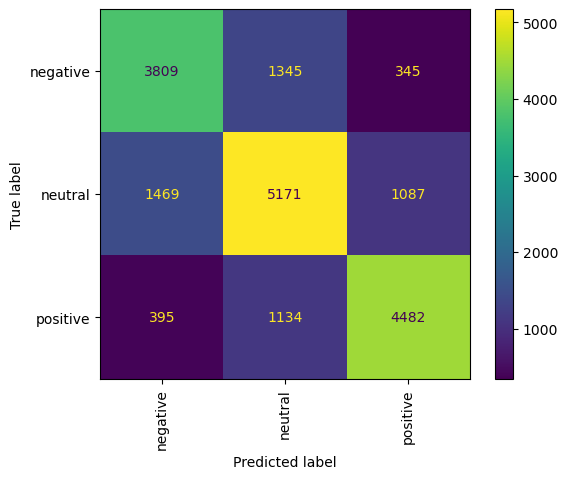

In [47]:
params_model={"max_iter":3000,'C':1,'class_weight': 'balanced'}
se_ = Sentiment_Evaluator(model = LogisticRegression,params_model=params_model)
#ENTRANAMIENTO
se_.fit(df_to_train,Y)

#RESULTADOS
se_.mostrar_tabla(df_to_train,Y)
se_.print_cv_results()

C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Program Files\Anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy arra

              precision    recall  f1-score   support

    negative       0.73      0.61      0.66      5499
     neutral       0.64      0.76      0.69      7727
    positive       0.78      0.71      0.75      6011

    accuracy                           0.70     19237
   macro avg       0.72      0.69      0.70     19237
weighted avg       0.71      0.70      0.70     19237

RESULTADOS
---------------------
Metrica f1_macro 
media: 0.683
std:0.008
min:0.673
max:0.695


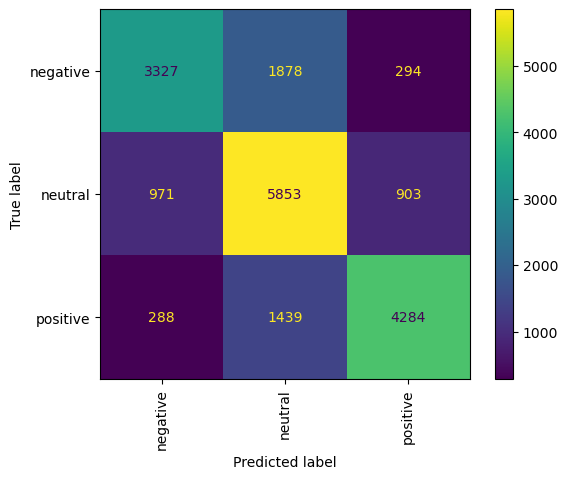

In [18]:
#ENTRANAMIENTO
se_.fit(df_to_train,Y)

#RESULTADOS
se_.mostrar_tabla(df_to_train,Y)
se_.print_cv_results()

# OPTIMIZACION MODELO LOG

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import ShuffleSplit

In [29]:
clf = LogisticRegression()

In [30]:
pipeline = Pipeline([ ('clf', clf)])
# pipeline.fit(X, Y)
# pipeline.named_steps.vect.get_params()
pipeline.named_steps.clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [43]:
cv = ShuffleSplit( n_splits=5, test_size=0.3,  random_state=0)
param_grid = dict(      
     clf__C=[ 0.01, 0.1, 1, 10, 100],
    # clf__C=[1],
     clf__max_iter= [3000],
     clf__l1_ratio= [None,0.3,0.5,0.8,1],
     clf__class_weight= [None, 'balanced'] )

grid_search = GridSearchCV(pipeline,
     param_grid=param_grid,
     cv=cv,
     scoring="f1_macro",
     verbose=1)
modelo = grid_search.fit(df_to_train, Y) 

In [45]:
mod2 = pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')
mod2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__class_weight,param_clf__l1_ratio,param_clf__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,14.869693,1.259082,0.072215,0.007269,1,balanced,0.3,3000,"{'clf__C': 1, 'clf__class_weight': 'balanced',...",0.674751,0.678015,0.680059,0.684918,0.684696,0.680488,0.003913,1
27,15.294808,1.166704,0.074352,0.006936,1,balanced,0.5,3000,"{'clf__C': 1, 'clf__class_weight': 'balanced',...",0.674751,0.678015,0.680059,0.684918,0.684696,0.680488,0.003913,1
28,15.446823,1.127692,0.098231,0.012477,1,balanced,0.8,3000,"{'clf__C': 1, 'clf__class_weight': 'balanced',...",0.674751,0.678015,0.680059,0.684918,0.684696,0.680488,0.003913,1
25,13.915868,1.821787,0.076329,0.010422,1,balanced,None,3000,"{'clf__C': 1, 'clf__class_weight': 'balanced',...",0.674751,0.678015,0.680059,0.684918,0.684696,0.680488,0.003913,1
29,15.181887,1.088982,0.085326,0.007415,1,balanced,1,3000,"{'clf__C': 1, 'clf__class_weight': 'balanced',...",0.674751,0.678015,0.680059,0.684918,0.684696,0.680488,0.003913,1
36,19.257073,0.768906,0.070897,0.008998,10,balanced,0.3,3000,"{'clf__C': 10, 'clf__class_weight': 'balanced'...",0.672738,0.676349,0.678455,0.685731,0.686160,0.679886,0.005276,6
39,19.330489,0.696039,0.063206,0.003684,10,balanced,1,3000,"{'clf__C': 10, 'clf__class_weight': 'balanced'...",0.672738,0.676349,0.678455,0.685731,0.686160,0.679886,0.005276,6
38,19.341882,0.686602,0.064918,0.004875,10,balanced,0.8,3000,"{'clf__C': 10, 'clf__class_weight': 'balanced'...",0.672738,0.676349,0.678455,0.685731,0.686160,0.679886,0.005276,6
37,19.299979,0.911786,0.066931,0.009780,10,balanced,0.5,3000,"{'clf__C': 10, 'clf__class_weight': 'balanced'...",0.672738,0.676349,0.678455,0.685731,0.686160,0.679886,0.005276,6
35,19.406349,0.971384,0.066158,0.004687,10,balanced,None,3000,"{'clf__C': 10, 'clf__class_weight': 'balanced'...",0.672738,0.676349,0.678455,0.685731,0.686160,0.679886,0.005276,6
